# generate videos of spiral tips with streams predictive of extinction dynamics
Tim Tyree<br>
3.22.2022

In [175]:
from lib.my_initialization import *
from lib.model.minimal_model_cuda import *
from lib import *
%autocall 1
%load_ext autoreload
%autoreload 2

In [215]:
import shutil
#reset matplotlib
import matplotlib as mpl
# import seaborn as sns
# sns.reset_orig()
mpl.rc_file_defaults()

In [162]:
# 993MiB /  7982MiB
# 7982/993=8.03...>8
npartitions_gpu=1
npartitions=os.cpu_count()-1
assert npartitions>0

# define module

In [376]:
#input: gpu output in cpu memory
#ouput:  dict_out,img,dimg_dt
def measure_system(gpu_result_u,gpu_result_v,gpu_result_w,V_threshold,**kwargs):
    """
    kwargs may not be conected to anything
    returns dict_out,img,dimg_dt
    Example Usage:
dict_out,img,dimg_dt=measure_system(gpu_result_u,gpu_result_v,gpu_result_w,V_threshold)
    """
    #stack txt
    txt=np.stack((gpu_result_u,gpu_result_v,gpu_result_w),axis=-1)
    # #DONE: compute spiral tip locations and verify that they look reasonable
    #compute flow map
    zero_txt=np.zeros_like(txt)
    dtxt_dt=zero_txt#.copy()
    get_time_step_fk(txt, dtxt_dt)
    img=txt[...,0]
    dimgdt=dtxt_dt[...,0]
    #compute spiral tip locations
    dict_out=compute_all_spiral_tips(t=9999.,img=img,dimgdt=dimgdt,level1=V_threshold,level2=0.)#,width=width,height=height)

    #compress data to be plotted
    # dimg_dt=dtxt_dt[...,0]
    # img=txt[...,0]
    dimg_dt=dtxt_dt[...,0].astype(np.float32) #looks the same as float64
    img=txt[...,0].astype(np.float32)
    # dVdt=dtxt_dt[...,0].astype(np.float16) #this bugs up the streamplots
    # img=txt[...,0].astype(np.float16)
    return dict_out,img,dimg_dt

In [378]:
#DONE: dev viewer routine_to_png
#input: dict_out,img,dimg_dt,save_dir
#output: save_dir
def routine_to_png_streaming_tips(task):
    dict_out,img,dimg_dt,save_dir=task
    #define constant parameters
    # fontsize=22
    # xy=(0.75, 0.9)
    inch=6
    fontsize=30
    xy=(0.67, 0.9)
    #define constant coordinate mesh for stream generation
    width=200.#pixel
    height=200.#pixel
    DX=0.025#cm/pixel
    #generate plot
    #fig, ax = plt.subplots(figsize=(inch,inch))#,constrained_layout=True)
    fig = plt.figure(figsize=(inch,inch))#,constrained_layout=True)
    ax=fig.add_subplot()
    ax.pcolormesh(X, Y, img, vmin=0.,vmax=1.,cmap='bone', shading='gouraud')
    #ax.pcolormesh(X, Y, img, vmin=0.,vmax=1.,cmap='bone', shading='auto')
    #     ax.pcolormesh(X, Y, img, vmin=0.,vmax=1.,cmap='bone')
    #     ax.pcolormesh(X, Y, img, shading='auto',cmap='bone')

    #compute the streamplot
    X_=np.arange(width)
    Y_=np.arange(height)
    #X,Y = np.meshgrid(X_, Y_)
    #compute vector field
    ddVdtdx=np.gradient(dimg_dt,axis=1)/DX
    ddVdtdy=np.gradient(dimg_dt,axis=0)/DX
    vx=-ddVdtdx #looks good
    vy=-ddVdtdy
    # vx=ddVdtdx #looks meh
    # vy=ddVdtdy
    strm = ax.streamplot(X_,Y_, vx, vy, color=(.75,.90,.93),integration_direction='both',
                         density=0.5)#density=2)#way too much 
    x_values=np.array(dict_out['x'])
    y_values=np.array(dict_out['y'])
    if x_values.shape[0]>0:
        boo=(x_values<width-1.)&(y_values<height-1.)
        x_values=x_values[boo]
        y_values=y_values[boo]
        start_points = list(zip(x_values,y_values))
        strmS = ax.streamplot(X_,Y_, vx, vy, start_points=start_points, 
                              color="crimson", #"orange", 
                              linewidth=2,
        #                       integration_direction='forward')
        #                       integration_direction='backward')
                              integration_direction='both')
        ax.scatter(x=x_values,y=y_values,color='yellow',marker='*',s=150,alpha=0.9,zorder=10)

    #complicated formatting
    #add text of label
#     label=f"Vth={V_threshold}"
    label=r"$-\nabla \partial_tV$"#+'\n'
    ax.annotate(label, xy=xy, 
                xycoords='axes fraction',
    #             xycoords='data',
    #             xycoords='polar',
                fontsize=fontsize,alpha=0.8)
    #add text box with label
    # anchored_text = mpl.offsetbox.AnchoredText(label, loc='upper right')
    # ax.add_artist(anchored_text)
    # anchored_text.set_alpha(0.1)
    # annotating=False
    # if annotating:
    #     time_step_string=f"  t = {t/10**3:.2f} sec"#f"  t = {t:.0f} ms"#
    #     message_string=f"  num. = {n_tips}"
    #     ax.text(.0,.95,time_step_string,
    #             horizontalalignment='left',color=textcolor,fontsize=fontsize,
    #             transform=ax.transAxes)
    #     ax.text(.0,.9,message_string,
    #             horizontalalignment='left',color=textcolor,fontsize=fontsize,
    #             transform=ax.transAxes)
    ax.axis("off")
    plt.savefig(save_dir,dpi=720/inch, bbox_inches='tight',pad_inches=0);
    plt.close();
    return save_dir

In [286]:
1

1

# test my gpu accelerated one_step method for the Fenton-Karma model

200000 time steps took 14355 ms.


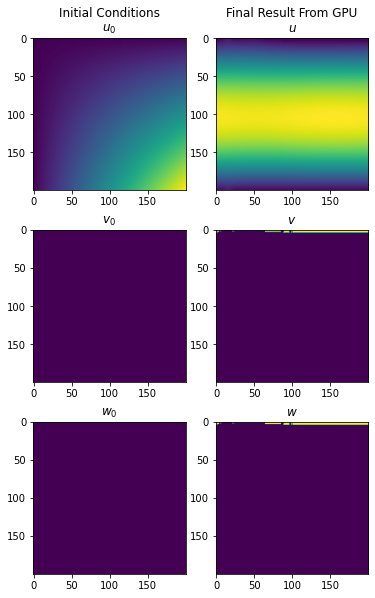

In [31]:
# from lib.model.minimal_model_cuda import *
#the following might be needed for the kernel_autotuner.
# drv.init()

#define how resources are used
width  = 200
height = 200
block_size_x=10
block_size_y=10
threads = (block_size_x,block_size_y,1)
grid = (int(width/block_size_x, int(height/block_size_y), 1)
block_size_string = f"#define block_size_x {block_size_x}\n#define block_size_y {block_size_y}\n"

#set spatial discretization
DX=0.025 #cm
# DY=0.025
DT=0.025 #ms

#initialize PyCuda and get compute capability needed for compilation
context = drv.Device(0).make_context()
devprops = { str(k): v for (k, v) in context.get_device().get_attributes().items() }
cc = str(devprops['COMPUTE_CAPABILITY_MAJOR']) + str(devprops['COMPUTE_CAPABILITY_MINOR'])

#load parameters for parameter set 8 for the Fenton-Karma Model
kwargs = read_parameters_from_json('lib/model/param_set_8.json')
kwargs['width']=width
kwargs['height']=height
kwargs['DX']=DX
# kwargs['DT']=DT
# kwargs['DY']=DY

#define the initial conditions
Vin  = np.array([256*x*(y+1) for x in range(width) for y in range(height)]).reshape((width,height))

u_initial = Vin.astype(np.float64)
#initialize auxiliary textures to zero
v_initial = np.zeros_like(u_initial)
w_initial = np.zeros_like(u_initial)

#don't allocate memory many times for the same task!
#allocate GPU memory for voltage scalar field
u_old = drv.mem_alloc(u_initial.nbytes)
u_new = drv.mem_alloc(u_initial.nbytes)

#allocate GPU memory for v and w auxiliary fields
v_old = drv.mem_alloc(v_initial.nbytes)
v_new = drv.mem_alloc(v_initial.nbytes)
w_old = drv.mem_alloc(w_initial.nbytes)
w_new = drv.mem_alloc(w_initial.nbytes)

# explicit time integration up to 5 seconds in steps of size 0.025 ms
kernel_string = get_kernel_string_FK_model(**kwargs, DT=DT)
iterations = 10**5

#setup thread block dimensions and compile the kernel
mod = SourceModule(block_size_string+kernel_string)
time_step_kernel = mod.get_function("time_step_kernel")

#create events for measuring performance
start = drv.Event()
end = drv.Event()

#move the data to the GPU
drv.memcpy_htod(u_old, u_initial)
drv.memcpy_htod(u_new, u_initial)
drv.memcpy_htod(v_old, v_initial)
drv.memcpy_htod(v_new, v_initial)
drv.memcpy_htod(w_old, w_initial)
drv.memcpy_htod(w_new, w_initial)

#call the GPU kernel 2*iterations times and measure performance
context.synchronize()
start.record()
for i in range(iterations):
    time_step_kernel(u_new, u_old, v_new, v_old, w_new, w_old, block=threads, grid=grid)
    time_step_kernel(u_old, u_new, v_old, v_new, w_old, w_new, block=threads, grid=grid)
end.record()
context.synchronize()
runtime = end.time_since(start)
print(f"{iterations*2} time steps took {runtime:.0f} ms.")

#copy the result from the GPU to Python for plotting
gpu_result_u = np.zeros_like(u_initial)
drv.memcpy_dtoh(gpu_result_u, u_old)
gpu_result_v = np.zeros_like(v_initial)
drv.memcpy_dtoh(gpu_result_v, v_old)
gpu_result_w = np.zeros_like(w_initial)
drv.memcpy_dtoh(gpu_result_w, w_old)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(6,10))
ax1.imshow(u_initial)
ax1.set_title("Initial Conditions\n$u_0$")
ax2.imshow(gpu_result_u)
ax2.set_title("Final Result From GPU\n$u$")

ax3.imshow(v_initial)
ax3.set_title("$v_0$")
ax4.imshow(gpu_result_v)
ax4.set_title("$v$")

ax5.imshow(w_initial)
ax5.set_title("$w_0$")
ax6.imshow(gpu_result_w)
ax6.set_title("$w$")
plt.show()

In [12]:
print_dict(kwargs)

diffCoef=0.0005
C_m=1.0
tau_pv=13.03
tau_v2=19.6
tau_v1=1250
tau_pw=800
tau_mw=40
tau_d=0.45
tau_0=12.5
tau_r=33.25
tau_si=29
K=10
V_sic=0.85
V_c=0.13
V_v=0.04
width=200
height=200
DX=0.025


## print the kernel_string for the one_step method for the Fenton-Karma model

In [362]:
print(kernel_string)


// primary model parameters
#define width  200
#define height 200
#define h      0.025
#define C_m    1.0
#define tau_pv 13.03
#define tau_v1 1250.0
#define tau_v2 19.6
#define tau_pw 800.0
#define tau_mw 40.0
#define tau_d  0.45
#define tau_0  12.5
#define tau_r  33.25
#define tau_si 29.0
#define K      10.0
#define V_sic  0.85
#define V_c    0.13
#define V_v    0.04

// auxiliary model parameters
#define nx width
#define ny height
#define dcoef 0.80000000

// periodic boundary conditions
__device__ int _pbc ( int q, int wid ) {
    if (q >= wid) {
        q = 0;
    }
    if (q < 0) {
        q = wid-1;
    }
    return q;
}

// heaviside step function
__device__ double step(double thresh, double x)
{
    return x >= thresh;
}

// main computation kernel/face shader
__global__ void time_step_kernel(double *u_new, double *u, double *v_new, double *v, double *w_new, double *w) {
    int x = blockIdx.x * block_size_x + threadIdx.x;
    int y = blockIdx.y * block_size_y + threadIdx.y;
 

# dev

In [382]:
from lib.viewer.viewer_cluster import *

In [ ]:
# #DONE: load from a whole other folder of initial condition from the Fenton-Karma model
# ic_fn=f"{nb_dir}/Data/initial-conditions-suite-1/ic-in/ic_200x200.108.13.npz"
# txt_fk=load_buffer(ic_fn)
# txt_fk.shape

In [385]:
# load an initial conditions and integrate forward 100ms
printing=False
tf=100.
iterations = int(np.around(tf/DT))
# ic_folder='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-in/'
ic_folder='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/'
# ic_fn='ic200x200.3.80.npz'
# ic_fn='ic200x200.2.80.npz'

ic_fn_lst=["ic200x200.0.0.npz",   "ic200x200.0.59.npz",  "ic200x200.1.34.npz",  "ic200x200.2.0.npz",   "ic200x200.2.59.npz",  "ic200x200.3.34.npz",
"ic200x200.0.10.npz",  "ic200x200.0.5.npz",   "ic200x200.1.35.npz",  "ic200x200.2.10.npz",  "ic200x200.2.5.npz",   "ic200x200.3.35.npz"]

for ic_fn in ic_fn_lst:
    ic_dir=os.path.join(ic_folder,ic_fn)
    if printing:
        print(f"ic_dir='{ic_dir}'")

    #load ic and verify that it contains spiral tips
    txt=load_buffer(ic_dir).astype(np.float64)
    # plt.imshow(txt[...,0],cmap='gray')
    # plt.axis('off')
    # plt.show()

    t=0

    # iterations = 67
    if printing:
        print(f"forward integrating to tf={tf:.3f} ms (iterations={iterations})...")

    #define the initial conditions
    u_initial=txt[...,0].copy()
    v_initial=txt[...,1].copy()
    w_initial=txt[...,2].copy()

    #don't allocate memory many times for the same task!
    #allocate GPU memory for voltage scalar field
    u_old = drv.mem_alloc(u_initial.nbytes)
    u_new = drv.mem_alloc(u_initial.nbytes)
    #allocate GPU memory for v and w auxiliary fields
    v_old = drv.mem_alloc(v_initial.nbytes)
    v_new = drv.mem_alloc(v_initial.nbytes)
    w_old = drv.mem_alloc(w_initial.nbytes)
    w_new = drv.mem_alloc(w_initial.nbytes)

    # explicit time integration up to 5 seconds in steps of size 0.025 ms
    kernel_string = get_kernel_string_FK_model(**kwargs, DT=DT)

    #setup thread block dimensions and compile the kernel
    mod = SourceModule(block_size_string+kernel_string)
    time_step_kernel = mod.get_function("time_step_kernel")

    # #create events for measuring performance
    # start_timer = drv.Event()
    # end_timer = drv.Event()

    #move the data to the GPU
    drv.memcpy_htod(u_old, u_initial)
    drv.memcpy_htod(u_new, u_initial)
    drv.memcpy_htod(v_old, v_initial)
    drv.memcpy_htod(v_new, v_initial)
    drv.memcpy_htod(w_old, w_initial)
    drv.memcpy_htod(w_new, w_initial)

    #call the GPU kernel 2*iterations times and measure performance
    context.synchronize()
    # start_timer.record()
    for i in range(iterations):
        time_step_kernel(u_new, u_old, v_new, v_old, w_new, w_old, block=threads, grid=grid)
        time_step_kernel(u_old, u_new, v_old, v_new, w_old, w_new, block=threads, grid=grid)
    # end_timer.record()
    context.synchronize()
    # runtime = end_timer.time_since(start_timer)
    print(f"{iterations*2} time steps took {runtime:.0f} ms.")

    #copy the result from the GPU to Python for plotting
    gpu_result_u = np.zeros_like(u_initial)
    drv.memcpy_dtoh(gpu_result_u, u_old)
    gpu_result_v = np.zeros_like(v_initial)
    drv.memcpy_dtoh(gpu_result_v, v_old)
    gpu_result_w = np.zeros_like(w_initial)
    drv.memcpy_dtoh(gpu_result_w, w_old)

    #record final time as new time
    t=tf

    # fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(6,10))
    # ax1.imshow(u_initial)
    # ax1.set_title("Initial Conditions\n$u_0$")
    # ax2.imshow(gpu_result_u)
    # ax2.set_title("Final Result From GPU\n$u$")
    # ax3.imshow(v_initial)
    # ax3.set_title("$v_0$")
    # ax4.imshow(gpu_result_v)
    # ax4.set_title("$v$")
    # ax5.imshow(w_initial)
    # ax5.set_title("$w_0$")
    # ax6.imshow(gpu_result_w)
    # ax6.set_title("$w$")
    # plt.show()

    #init methods for instantaneous spiral tip detection
    diffCoef=kwargs['diffCoef']
    dsdpixel=kwargs['DX']
    get_time_step_fk,one_step_fk=recall_flow_map_fk(nb_dir=nb_dir,diffCoef=diffCoef,width=width,height=height,dsdpixel=dsdpixel)
    # one_step_luo_rudy,comp_distance,comp_dict_tips=init_methods(nb_dir=nb_dir,width=width,height=height,ds=DX,dt=DT,V_threshold=0.4,jump_threshold=40)
    # V_threshold=-60
    V_threshold=0.4
    compute_all_spiral_tips= get_compute_all_spiral_tips(mode='simp',width=width,height=height)

    #stack txt
    txt=np.stack((gpu_result_u,gpu_result_v,gpu_result_w),axis=-1)
    #cache txt for initialization
    txt_init=txt.copy()

    zero_txt=np.zeros_like(txt)

    # #compute flow map
    # dtxt_dt=zero_txt.copy()
    # get_time_step_fk(txt, dtxt_dt)
    # plt.imshow(dtxt_dt[...,0],cmap='bone',vmin=0,vmax=0.5)
    # plt.axis('off')
    # plt.show()

    #compute spiral tip locations and verify that they look reasonable
    #compute flow map
    dtxt_dt=zero_txt.copy()
    get_time_step_fk(txt, dtxt_dt)
    img=txt[...,0]
    dimgdt=dtxt_dt[...,0]
    #compute spiral tip locations
    dict_out=compute_all_spiral_tips(t,img,dimgdt,level1=V_threshold,level2=0.)#,width=width,height=height)
    print_dict(dict_out)
    if dict_out['n']>0:
        #generation of results
        # printing=True
        save_every=67
        fps=60 #i checked the ffmpeg routine
        # video_duration=30 #seconds
        video_duration=15 #seconds
        pause_after_termination_duration=1. #second
        accumulated_time_after_termination=0.
        V_threshold=0.4 #appears best
        # V_threshold=0.2
        # V_threshold=0.8
        # V_threshold=0.95
        #NOTE: I can make video_duration=30*6 #seconds so long as I am not storing more in ram at a time
        
        #define the initial conditions
        t=tf #ms
        txt=txt_init.copy()
        u_initial=txt[...,0].copy()
        v_initial=txt[...,1].copy()
        w_initial=txt[...,2].copy()

        #don't allocate memory many times for the same task!
        #allocate GPU memory for voltage scalar field
        u_old = drv.mem_alloc(u_initial.nbytes)
        u_new = drv.mem_alloc(u_initial.nbytes)
        #allocate GPU memory for v and w auxiliary fields
        v_old = drv.mem_alloc(v_initial.nbytes)
        v_new = drv.mem_alloc(v_initial.nbytes)
        w_old = drv.mem_alloc(w_initial.nbytes)
        w_new = drv.mem_alloc(w_initial.nbytes)

        # explicit time integration up to 5 seconds in steps of size 0.025 ms
        kernel_string = get_kernel_string_FK_model(**kwargs, DT=DT)

        #setup thread block dimensions and compile the kernel
        mod = SourceModule(block_size_string+kernel_string)
        time_step_kernel = mod.get_function("time_step_kernel")

        # #create events for measuring gpu performance
        # start_timer = drv.Event()
        # end_timer = drv.Event()

        #move the data to the GPU
        drv.memcpy_htod(u_old, u_initial)
        drv.memcpy_htod(u_new, u_initial)
        drv.memcpy_htod(v_old, v_initial)
        drv.memcpy_htod(v_new, v_initial)
        drv.memcpy_htod(w_old, w_initial)
        drv.memcpy_htod(w_new, w_initial)

        #time evolve txt on gpu saving to cpu once every 67 time steps
        iterations=save_every
        number_frames=np.around(video_duration*fps)
        nsteps=number_frames
        t_final=tf+DT*iterations*nsteps
        if printing:
            print(f"system initialized at time: {t} ms")
            print(f"saving at a 10/1.05 ~ 10X slowdown from the time in the simulation (supposing 60 fps)")
            print(f"forward integrating to tf={t_final/1e3} seconds...")
        dict_out_lst=[]
        img_lst=[]
        dimg_dt_lst=[]
        start = time.time()
        for step in range(nsteps):
            #call the GPU kernel 2*iterations times and measure performance
            context.synchronize()
            #start_timer.record()
            for i in range(iterations):
                time_step_kernel(u_new, u_old, v_new, v_old, w_new, w_old, block=threads, grid=grid)
                time_step_kernel(u_old, u_new, v_old, v_new, w_old, w_new, block=threads, grid=grid)
            #end_timer.record()
            context.synchronize()
            #runtime = end_timer.time_since(start_timer)

            #copy the result from the GPU to Python for plotting
            gpu_result_u = np.zeros_like(u_initial)
            drv.memcpy_dtoh(gpu_result_u, u_old)
            gpu_result_v = np.zeros_like(v_initial)
            drv.memcpy_dtoh(gpu_result_v, v_old)
            gpu_result_w = np.zeros_like(w_initial)
            drv.memcpy_dtoh(gpu_result_w, w_old)

            #measure
            dict_out,img,dimg_dt=measure_system(gpu_result_u,gpu_result_v,gpu_result_w,V_threshold)
            #update time
            t=(tf+DT*step*iterations)*0.001 #seconds
            dict_out['t']=t
            #record
            dict_out_lst.append(dict_out)
            img_lst.append(img)
            dimg_dt_lst.append(dimg_dt)
            #update progressbar
            if printing:
                printProgressBar(step + 1, nsteps, prefix = f'Progress:', suffix = f'Complete (t={t:.3f} seconds)', length = 50)

            if dict_out['n']==0:
                #the number of tips is zero
                accumulated_time_after_termination+=DT*iterations
                if accumulated_time_after_termination>pause_after_termination_duration:
                    # break the inner loop
                    break
            else:
                # continue if the inner loop wasn't broken
                continue
            # inner loop was broken, break the outer
            break

        runtime = time.time() - start
        if printing:
            print(f"simulation complete!\ntotal run time: {runtime:.0f} seconds for {ic_fn}.")
        # beep(1)

        #generate movie of data currently in virtual memory
        dump_cache=True
        save_folder = os.path.join(nb_dir,f'Figures/mov')
        #dump save_folder if it already exists
        if not os.path.exists(save_folder):
            os.mkdir(save_folder)
        assert (os.path.exists(save_folder))
        if dump_cache:
            shutil.rmtree(save_folder)
            print(f"dumped cache at {save_folder}")
            os.mkdir(save_folder)

        task_lst=[]
        for frameno,(dict_out,img,dimg_dt) in enumerate(zip(dict_out_lst,img_lst,dimg_dt_lst)):
            save_fn=f"img{frameno:07d}.png"
            save_dir=os.path.join(save_folder,save_fn)
            task=dict_out,img,dimg_dt,save_dir
            task_lst.append(task)
        task_lst.pop(-1)
        if printing:
            print(f"added {len(task_lst)} tasks to task_lst")

        testing=False
        if testing:
            task_index=-100
            task = task_lst[task_index]
            routine_to_png_streaming_tips(task)
            if printing:
                print(task[-1])

        if printing:
            print(f"NOTA BENE: to check on plotting progess in terminal, go to {save_folder} and enter:\n*** ls | wc -l ***")
            print (f"estimated run time for plotting ~{6*len(dict_out_lst)/npartitions/60:.1f} minutes...")
            print  ("estimated run time ~ 1 hour per trial... mpl isn't parallelizing right...")
            #as is, it's about a 5X undertime...  this suggests 16*5/60 hours is roughly the expected run time

        # # DONE: make the stream plot with this particle current, as before, but only where there are particles
        # #     - option 0: ignore the following details and just do what I already did.
        # #     - option 1: add streams with periodic boundary conditions (only if easy fix found on stackoverflow!)
        # #     - option 2: add streams on the interior only
        # #DONE: save ^that to .png with zero borders, as before
        # #DONE: wrap ^that into a viewer routine_to_png(task)
        # #TODO: eval_viewer_cluster
        #this took 1 hour for 1 trial
        start=time.time()
        if printing:
            print(f"generating {len(task_lst)} .png files over {len(npartitions)} cores...")
        retval=eval_viewer_cluster(task_lst=task_lst,routine_to_png=routine_to_png_streaming_tips,npartitions=npartitions,printing=False)
        if printing:
            print(f"the apparent run time for plotting was {(time.time()-start)/60:.1f} minutes")
        #beep(2)
        #NOTE: the following was much slower
        # #concatenate the folder of png files to a video
        # os.chdir(f"{nb_dir}/../vid/src")
        # !./concat_folder_png.sh
        # if printing:
        #     print(f"V_threshold={V_threshold}")
        # beep(3)
        #concatenate the folder of png files to a video
        os.chdir(f"{nb_dir}/../vid/src")
        os.system("./concat_folder_png.sh");
        #copy output movie to a file uniquely named for this recording session
        # fn=ic_fn
        fn=os.path.basename(ic_dir)
        save_mov_fn=fn.replace('.npz','_streaming_tips.mov')
        os.chdir(f"{nb_dir}/../vid/mov")
        folder=f'streaming_tips_fenton_karma_diffCoef_{diffCoef}'
        if not os.path.exists(folder):
            os.mkdir(folder)
        os.system(f"cp out.mov {os.path.join(folder,save_mov_fn)}")
        # beep(3)
        if printing:
            print(f"{os.path.abspath(save_mov_fn)}")
        #save dict_out_lst to .pkl in new folder in Data/
        save_pkl_folder=os.path.join(ic_folder,'..',folder)
        if not os.path.exists(save_pkl_folder):
            os.mkdir(save_pkl_folder)
        save_pkl_fn=fn.replace('.npz','.pkl')
        save_pkl_dir=os.path.join(save_pkl_folder,save_pkl_fn)
        save_to_pkl(save_pkl_dir,dict_out_lst)
        print(f"save_pkl_dir='{save_pkl_dir}'")

8000 time steps took 40 ms.
param_fn is param_set_8.json.
t=100.0
n=4
x=[47.70461999486014, 57.502692892985685, 114.9745263162495, 174.08240644565404]
y=[130.32990113166036, 160.0729817770988, 14.145258157437949, 119.2985635346965]
grad_ux=[0.36029275957792317, 1.376542188512733, 0.863307370513411, 0.7187016415982683]
grad_uy=[1.2303286764719392, 0.8645659396024787, 2.070882090091564, 1.4128924517481047]
grad_vx=[1.7888276476205653, -0.9891870829127515, 1.0702180362237466, 5.394408377345041]
grad_vy=[0.7097386572508284, 1.7133260245974722, 0.42654091158790974, -5.413771303847788]
dumped cache at /home/timothytyree/Documents/GitHub/care/notebooks/Figures/mov


ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

frame=  240 fps=0.0 q=0.0 Lsize=    1152kB time=00:00:04.01 bitrate=2352.8kbits/s speed=15.3x    
video:894kB audio:189kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 6.425173%
ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq

frame= 2399 fps=235 q=-1.0 Lsize=    5009kB time=00:00:39.93 bitrate=1027.6kbits/s dup=1 drop=0 speed=3.91x    
video:4976kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.658230%
[libx264 @ 0x560b30df0c80] frame I:12    Avg QP:29.73  size: 12305
[libx264 @ 0x560b30df0c80] frame P:727   Avg QP:33.05  size:  4717
[libx264 @ 0x560b30df0c80] frame B:1660  Avg QP:30.12  size:   914
[libx264 @ 0x560b30df0c80] consecutive B-frames:  4.6%  7.1%  7.1% 81.2%
[libx264 @ 0x560b30df0c80] mb I  I16..4: 26.0% 65.9%  8.1%
[libx264 @ 0x560b30df0c80] mb P  I16..4:  3.2%  7.3%  1.3%  P16..4: 17.4%  3.5%  0.9%  0.0%  0.0%    skip:66.5%
[libx264 @ 0x560b30df0c80] mb B  I16..4:  0.2%  0.4%  0.1%  B16..8: 11.9%  0.8%  0.1%  direct: 0.1%  skip:86.4%  L0:51.5% L1:47.1% BI: 1.3%
[libx264 @ 0x560b30df0c80] 8x8 transform intra:61.9% inter:75.3%
[libx264 @ 0x560b30df0c80] coded y,uvDC,uvAC intra: 19.7% 27.0% 4.5% inter: 1.1% 1.1% 0.3%
[libx264 @ 0x560b30df0c80] i16 v,h,dc,p: 35% 22

save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out//../mov_pkl_fk_diffCoef_0.0005/ic200x200.0.0.pkl'
134 time steps took 40 ms.
param_fn is param_set_8.json.
t=100.0
n=22
x=[1.425904870342321, 15.384482600315161, 29.957515139309013, 42.1810708938391, 56.59958896988973, 58.895429741859644, 62.63989974329696, 68.98437204317415, 100.18911183078572, 106.5725264792845, 125.53612071038518, 145.89358356017527, 150.37406497373595, 155.4865134326228, 163.60799263092642, 173.8867174899651, 187.69347862551234, 192.19600078183757, 197.43620720246116, 198.89426148558644, 198.8285405121821, 199.04073218534487]
y=[199.16217809166113, 79.22123031562413, 8.678922153908792, 94.67756551791999, 97.02070767196763, 96.73451330504903, 199.4129562799137, 50.16546758628122, 0.033478763819900705, 118.82458886196231, 199.14188617743739, 51.58860185093297, 99.26888217017641, 197.1219788698454, 76.42428814568578, 197.59855966008993, 199.85293408943951, 48.158

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

frame=  240 fps=0.0 q=0.0 Lsize=    1152kB time=00:00:04.01 bitrate=2352.8kbits/s speed=15.4x    
video:894kB audio:189kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 6.425173%
ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq

frame= 2399 fps=237 q=-1.0 Lsize=    4901kB time=00:00:39.93 bitrate=1005.4kbits/s dup=1 drop=0 speed=3.94x    
video:4867kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.671015%
[libx264 @ 0x561ea6d04c80] frame I:11    Avg QP:28.78  size: 12291
[libx264 @ 0x561ea6d04c80] frame P:753   Avg QP:33.20  size:  4511
[libx264 @ 0x561ea6d04c80] frame B:1635  Avg QP:30.19  size:   888
[libx264 @ 0x561ea6d04c80] consecutive B-frames:  6.0%  7.3%  6.8% 80.0%
[libx264 @ 0x561ea6d04c80] mb I  I16..4: 30.3% 61.6%  8.1%
[libx264 @ 0x561ea6d04c80] mb P  I16..4:  2.7%  7.0%  1.3%  P16..4: 17.3%  3.4%  0.9%  0.0%  0.0%    skip:67.4%
[libx264 @ 0x561ea6d04c80] mb B  I16..4:  0.2%  0.4%  0.1%  B16..8: 11.9%  0.8%  0.1%  direct: 0.1%  skip:86.5%  L0:52.2% L1:46.5% BI: 1.3%
[libx264 @ 0x561ea6d04c80] 8x8 transform intra:63.2% inter:75.0%
[libx264 @ 0x561ea6d04c80] coded y,uvDC,uvAC intra: 19.4% 26.2% 4.4% inter: 1.1% 1.0% 0.3%
[libx264 @ 0x561ea6d04c80] i16 v,h,dc,p: 36% 21

save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out//../mov_pkl_fk_diffCoef_0.0005/ic200x200.0.59.pkl'
134 time steps took 38 ms.
param_fn is param_set_8.json.
t=100.0
n=12
x=[0.26462881620756906, 13.992335507485235, 16.074500303592426, 36.93479483505683, 42.06087766970766, 64.54665206586627, 72.85585629465369, 90.2024645937604, 150.91032274993808, 169.44362875376706, 197.79642072713807, 199.35271012375435]
y=[99.10707373837, 25.06538816355835, 171.17739591523468, 53.95336172007949, 199.2431299641119, 0.2069507357731878, 122.52762877012064, 199.75394503033215, 0.5181055864778411, 191.99228186001474, 83.1605595097486, 46.02593906181059]
grad_ux=[461.44432574778006, -0.3897039939854423, 1.4599950871452976, -0.2568802006736128, -0.641983948667567, 1.0377599162760074, -3.3781705522632977, 0.5055873317307389, 0.9769749148280744, 0.6040828175806556, 1.0574734202316587, 1.3098220492802124]
grad_uy=[-0.23052734262039914, 1.7613796197351161

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

frame=  240 fps=0.0 q=0.0 Lsize=    1152kB time=00:00:04.01 bitrate=2352.8kbits/s speed=15.5x    
video:894kB audio:189kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 6.425173%
ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq

frame= 2207 fps=241 q=-1.0 Lsize=    4516kB time=00:00:36.73 bitrate=1007.1kbits/s dup=1 drop=0 speed=4.01x    
video:4484kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.681067%
[libx264 @ 0x55f7d544dc80] frame I:10    Avg QP:29.24  size: 12573
[libx264 @ 0x55f7d544dc80] frame P:683   Avg QP:32.91  size:  4517
[libx264 @ 0x55f7d544dc80] frame B:1514  Avg QP:30.07  size:   911
[libx264 @ 0x55f7d544dc80] consecutive B-frames:  5.8%  6.9%  3.9% 83.4%
[libx264 @ 0x55f7d544dc80] mb I  I16..4: 25.8% 66.2%  8.0%
[libx264 @ 0x55f7d544dc80] mb P  I16..4:  2.7%  7.1%  1.3%  P16..4: 16.7%  3.4%  0.9%  0.0%  0.0%    skip:67.9%
[libx264 @ 0x55f7d544dc80] mb B  I16..4:  0.2%  0.4%  0.1%  B16..8: 12.1%  0.8%  0.1%  direct: 0.1%  skip:86.2%  L0:50.3% L1:48.4% BI: 1.3%
[libx264 @ 0x55f7d544dc80] 8x8 transform intra:63.3% inter:74.5%
[libx264 @ 0x55f7d544dc80] coded y,uvDC,uvAC intra: 19.8% 26.1% 4.5% inter: 1.1% 1.0% 0.3%
[libx264 @ 0x55f7d544dc80] i16 v,h,dc,p: 35% 22

save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out//../mov_pkl_fk_diffCoef_0.0005/ic200x200.1.34.pkl'
134 time steps took 34 ms.
param_fn is param_set_8.json.
t=100.0
n=16
x=[0.3282500159291951, 0.45500077215210366, 63.367083541247965, 68.03904116300065, 82.69933621663094, 100.07249959100078, 108.38602616868442, 115.31223778474512, 122.95064149887232, 127.54075679842815, 149.46008901051724, 164.60051847700484, 168.0571198866744, 178.45279049400392, 186.0621792375885, 199.57863400758933]
y=[40.76705159099225, 49.458994711914436, 43.22319835264015, 1.5473352711541086, 199.75192887889335, 195.91464058819676, 66.3560156575295, 186.93493856285082, 189.07487116869174, 199.51983676825677, 198.79767771754683, 52.10923436883153, 0.2742009051694624, 198.6374715973594, 129.0692136661084, 144.69350460934078]
grad_ux=[-5.808731398322933, 8.220238976215324, -3.1422764170934605, 1.0451819264539575, 2.149406906018892, -0.35248499253921384, -5.140

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

frame=  240 fps=0.0 q=0.0 Lsize=    1152kB time=00:00:04.01 bitrate=2352.8kbits/s speed=16.7x    
video:894kB audio:189kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 6.425173%
ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq

frame= 1381 fps=262 q=-1.0 Lsize=    2822kB time=00:00:22.96 bitrate=1006.4kbits/s dup=1 drop=0 speed=4.35x    
video:2799kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.754479%
[libx264 @ 0x55d11826fc80] frame I:7     Avg QP:28.37  size: 12571
[libx264 @ 0x55d11826fc80] frame P:407   Avg QP:32.43  size:  4650
[libx264 @ 0x55d11826fc80] frame B:967   Avg QP:29.57  size:   915
[libx264 @ 0x55d11826fc80] consecutive B-frames:  4.2%  5.8%  4.6% 85.4%
[libx264 @ 0x55d11826fc80] mb I  I16..4: 28.5% 62.4%  9.0%
[libx264 @ 0x55d11826fc80] mb P  I16..4:  2.8%  7.1%  1.4%  P16..4: 16.1%  3.4%  0.9%  0.0%  0.0%    skip:68.4%
[libx264 @ 0x55d11826fc80] mb B  I16..4:  0.2%  0.4%  0.1%  B16..8: 11.2%  0.8%  0.1%  direct: 0.1%  skip:87.1%  L0:51.4% L1:47.1% BI: 1.5%
[libx264 @ 0x55d11826fc80] 8x8 transform intra:62.3% inter:74.5%
[libx264 @ 0x55d11826fc80] coded y,uvDC,uvAC intra: 20.6% 27.3% 5.2% inter: 1.1% 1.1% 0.4%
[libx264 @ 0x55d11826fc80] i16 v,h,dc,p: 37% 22

save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out//../mov_pkl_fk_diffCoef_0.0005/ic200x200.2.0.pkl'
134 time steps took 20 ms.
param_fn is param_set_8.json.
t=100.0
n=14
x=[0.946694060852398, 22.387988274897207, 35.12019057240131, 48.420407595922214, 49.96160108269226, 71.09603800822654, 73.73955602903713, 94.82917730035963, 118.75267123812871, 129.5081876674141, 156.1550628813481, 187.82762006276306, 191.8526416524651, 192.50758995733392]
y=[69.73947580807749, 194.72883293392033, 198.19274089747103, 27.614279934850458, 179.51183121225577, 107.11107648107429, 199.02925640085977, 166.81849372385156, 199.56775741724394, 141.393296114777, 197.62833951425478, 117.22025374650626, 0.9291750076995355, 23.355008333325312]
grad_ux=[1.059352680763815, 1.8602600614077893, 0.24410315780865258, -9.085650214701701, 0.03386127731827088, 3.6871390608155292, 0.7471306994486552, 2.2986164066572377, 0.7792061077836067, -5.04840500617248, 0.13975667

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

frame=  240 fps=0.0 q=0.0 Lsize=    1152kB time=00:00:04.01 bitrate=2352.8kbits/s speed=15.6x    
video:894kB audio:189kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 6.425173%
ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq

frame= 2214 fps=233 q=-1.0 Lsize=    4758kB time=00:00:36.85 bitrate=1057.8kbits/s dup=1 drop=0 speed=3.88x    
video:4727kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.648783%
[libx264 @ 0x561e98995c80] frame I:11    Avg QP:29.56  size: 12455
[libx264 @ 0x561e98995c80] frame P:678   Avg QP:33.22  size:  4847
[libx264 @ 0x561e98995c80] frame B:1525  Avg QP:30.11  size:   929
[libx264 @ 0x561e98995c80] consecutive B-frames:  5.8%  5.6%  4.6% 84.0%
[libx264 @ 0x561e98995c80] mb I  I16..4: 26.4% 66.5%  7.2%
[libx264 @ 0x561e98995c80] mb P  I16..4:  3.0%  7.3%  1.4%  P16..4: 17.4%  3.6%  0.9%  0.0%  0.0%    skip:66.5%
[libx264 @ 0x561e98995c80] mb B  I16..4:  0.2%  0.4%  0.1%  B16..8: 11.6%  0.8%  0.1%  direct: 0.1%  skip:86.7%  L0:50.7% L1:47.9% BI: 1.5%
[libx264 @ 0x561e98995c80] 8x8 transform intra:62.4% inter:75.1%
[libx264 @ 0x561e98995c80] coded y,uvDC,uvAC intra: 20.5% 27.4% 5.0% inter: 1.2% 1.1% 0.4%
[libx264 @ 0x561e98995c80] i16 v,h,dc,p: 36% 22

save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out//../mov_pkl_fk_diffCoef_0.0005/ic200x200.2.59.pkl'
134 time steps took 35 ms.
param_fn is param_set_8.json.
t=100.0
n=18
x=[0.44153568369878043, 3.4067169405440563, 14.243161264656306, 18.42512615630993, 23.03310048980704, 23.50734795205407, 26.981769672544292, 30.06910774169848, 75.76471050975083, 83.01414089064761, 95.69657724245452, 150.78232319884472, 155.78644037791045, 170.3908539176258, 178.58057057509728, 196.92151084451837, 197.71626518895144, 198.15882996254095]
y=[65.72569486297493, 90.08087639888112, 37.22948638047602, 78.04160065234015, 63.98157338059075, 88.29148043584054, 199.17766265776825, 0.025231009553496136, 183.79356802258985, 1.321856851584035, 27.802145270766694, 12.814607132939077, 121.55752699076972, 105.28834231205389, 56.645522188126066, 14.88901144676805, 101.80310466158113, 100.99281403642259]
grad_ux=[-0.31947686933226965, 0.032223166175672675, 0.6125

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

frame=  240 fps=0.0 q=0.0 Lsize=    1152kB time=00:00:04.01 bitrate=2352.8kbits/s speed=14.9x    
video:894kB audio:189kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 6.425173%
ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq

frame= 2399 fps=236 q=-1.0 Lsize=    4869kB time=00:00:39.93 bitrate= 998.8kbits/s dup=1 drop=0 speed=3.93x    
video:4835kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.678264%
[libx264 @ 0x563037ba9c80] frame I:11    Avg QP:29.03  size: 12061
[libx264 @ 0x563037ba9c80] frame P:743   Avg QP:32.97  size:  4496
[libx264 @ 0x563037ba9c80] frame B:1645  Avg QP:30.13  size:   898
[libx264 @ 0x563037ba9c80] consecutive B-frames:  5.5%  7.3%  5.5% 81.7%
[libx264 @ 0x563037ba9c80] mb I  I16..4: 26.9% 65.5%  7.6%
[libx264 @ 0x563037ba9c80] mb P  I16..4:  2.9%  6.9%  1.3%  P16..4: 17.2%  3.3%  0.8%  0.0%  0.0%    skip:67.6%
[libx264 @ 0x563037ba9c80] mb B  I16..4:  0.2%  0.4%  0.1%  B16..8: 12.0%  0.8%  0.1%  direct: 0.1%  skip:86.4%  L0:51.5% L1:47.2% BI: 1.3%
[libx264 @ 0x563037ba9c80] 8x8 transform intra:62.1% inter:74.7%
[libx264 @ 0x563037ba9c80] coded y,uvDC,uvAC intra: 19.6% 26.1% 4.2% inter: 1.1% 1.0% 0.2%
[libx264 @ 0x563037ba9c80] i16 v,h,dc,p: 35% 22

save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out//../mov_pkl_fk_diffCoef_0.0005/ic200x200.3.34.pkl'
134 time steps took 37 ms.
param_fn is param_set_8.json.
t=100.0
n=12
x=[32.86030144338684, 33.49067883495214, 49.63772279974237, 62.00024554180479, 65.75623315859556, 77.61996955062051, 105.84640722964447, 121.12291362863088, 150.29718504946445, 152.81215173050947, 157.59235650800957, 199.53885730961053]
y=[41.266711970722696, 138.19717563161086, 0.09411210952568963, 106.94630859589371, 60.595400362058285, 199.65820295029093, 2.306354840976742, 117.25754061574793, 196.87779791354737, 27.583753182402585, 110.24689517978574, 159.80595429857968]
grad_ux=[-0.17812111298031996, 6.87040503014719, 1.0350870706841626, 1.4335882934555002, 3.993603383397098, 0.6190775727148887, 1.036400294311622, 2.3740356062820096, 15.298586976137866, 0.202760882428173, 1.1392967272896746, 1.091445000073668]
grad_uy=[1.915340867678687, -0.4241477581598903

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

frame=  240 fps=0.0 q=0.0 Lsize=    1152kB time=00:00:04.01 bitrate=2352.8kbits/s speed=15.7x    
video:894kB audio:189kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 6.425173%
ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq

frame= 1871 fps=256 q=-1.0 Lsize=    3660kB time=00:00:31.13 bitrate= 963.2kbits/s dup=1 drop=0 speed=4.26x    
video:3633kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.734103%
[libx264 @ 0x55f9c57b5c80] frame I:9     Avg QP:29.28  size: 12033
[libx264 @ 0x55f9c57b5c80] frame P:572   Avg QP:32.94  size:  4368
[libx264 @ 0x55f9c57b5c80] frame B:1290  Avg QP:29.83  size:   862
[libx264 @ 0x55f9c57b5c80] consecutive B-frames:  5.4%  6.0%  6.1% 82.5%
[libx264 @ 0x55f9c57b5c80] mb I  I16..4: 26.5% 65.4%  8.0%
[libx264 @ 0x55f9c57b5c80] mb P  I16..4:  2.7%  6.9%  1.3%  P16..4: 16.5%  3.3%  0.8%  0.0%  0.0%    skip:68.5%
[libx264 @ 0x55f9c57b5c80] mb B  I16..4:  0.2%  0.4%  0.1%  B16..8: 11.7%  0.8%  0.1%  direct: 0.1%  skip:86.6%  L0:52.8% L1:46.0% BI: 1.2%
[libx264 @ 0x55f9c57b5c80] 8x8 transform intra:63.0% inter:74.2%
[libx264 @ 0x55f9c57b5c80] coded y,uvDC,uvAC intra: 19.1% 25.6% 4.4% inter: 1.0% 0.9% 0.2%
[libx264 @ 0x55f9c57b5c80] i16 v,h,dc,p: 35% 23

save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out//../mov_pkl_fk_diffCoef_0.0005/ic200x200.0.10.pkl'
134 time steps took 29 ms.
param_fn is param_set_8.json.
t=100.0
n=16
x=[0.13315284101805772, 0.002854815555647142, 10.59642098919405, 23.651909404352445, 36.051998929770384, 40.55122501246291, 54.51593747273381, 87.46317997452442, 128.7012263993354, 168.70862818558635, 171.74669608100456, 183.2190204908096, 184.38731317343667, 198.86379534214015, 198.26084163289391, 199.19625516989873]
y=[13.356570004151372, 125.94556995625989, 0.028234496787931558, 12.35570808486233, 197.37186346328144, 15.110203681810939, 64.32975432366362, 35.14877781363103, 14.898534181030696, 115.89287096109334, 9.761524332703786, 108.31948895917266, 0.17484791391673105, 59.626346103249446, 73.18161470096949, 0.27002203698466487]
grad_ux=[-6.110000873930553, 82.28840391619899, 0.9859440920780778, 1.4563090357256412, 0.7399824511451342, 1.363065707920628, -2.

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

frame=  240 fps=0.0 q=0.0 Lsize=    1152kB time=00:00:04.01 bitrate=2352.8kbits/s speed=15.6x    
video:894kB audio:189kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 6.425173%
ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq

frame= 1818 fps=257 q=-1.0 Lsize=    3603kB time=00:00:30.25 bitrate= 975.7kbits/s dup=1 drop=0 speed=4.27x    
video:3576kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.728085%
[libx264 @ 0x557a7a55fc80] frame I:8     Avg QP:28.69  size: 11966
[libx264 @ 0x557a7a55fc80] frame P:567   Avg QP:32.53  size:  4405
[libx264 @ 0x557a7a55fc80] frame B:1243  Avg QP:29.73  size:   859
[libx264 @ 0x557a7a55fc80] consecutive B-frames:  5.7%  7.7%  5.0% 81.6%
[libx264 @ 0x557a7a55fc80] mb I  I16..4: 26.9% 65.4%  7.7%
[libx264 @ 0x557a7a55fc80] mb P  I16..4:  2.7%  6.7%  1.3%  P16..4: 16.5%  3.3%  0.8%  0.0%  0.0%    skip:68.6%
[libx264 @ 0x557a7a55fc80] mb B  I16..4:  0.2%  0.4%  0.1%  B16..8: 11.8%  0.7%  0.1%  direct: 0.1%  skip:86.6%  L0:51.8% L1:47.0% BI: 1.2%
[libx264 @ 0x557a7a55fc80] 8x8 transform intra:62.5% inter:74.0%
[libx264 @ 0x557a7a55fc80] coded y,uvDC,uvAC intra: 19.3% 25.8% 4.4% inter: 1.0% 0.9% 0.2%
[libx264 @ 0x557a7a55fc80] i16 v,h,dc,p: 37% 21

save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out//../mov_pkl_fk_diffCoef_0.0005/ic200x200.0.5.pkl'
134 time steps took 28 ms.
param_fn is param_set_8.json.
t=100.0
n=10
x=[0.23209862457454486, 0.23294633385532168, 38.712242037245716, 40.28198046921618, 89.99389281207087, 115.40320675401598, 115.37826874815194, 188.27248167416712, 190.06715130445738, 196.43780943671254]
y=[48.10996983474352, 68.1410825378442, 2.653309549252892, 69.63650336080404, 47.950954110646855, 18.327918502696154, 199.24392370379374, 198.8586994959372, 168.5085853458271, 118.27486384829312]
grad_ux=[114.10257748843031, -20.84742384801988, 1.0289168439137804, 1.602571685931977, 0.8327948265622597, 2.2448104693177515, 0.19450597305932982, 0.1745929732917631, -0.6786556596336842, -1.1443557943830398]
grad_uy=[0.45207850073974765, 1.0725103928094244, 0.43627689161158484, 0.6459799793192686, 1.3138557062657188, -6.794729170406109, 1.464799452485795, 1.78023074266

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

frame=  240 fps=0.0 q=0.0 Lsize=    1152kB time=00:00:04.01 bitrate=2352.8kbits/s speed=16.6x    
video:894kB audio:189kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 6.425173%
ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq

frame=  426 fps=355 q=-1.0 Lsize=     423kB time=00:00:07.05 bitrate= 491.3kbits/s dup=1 drop=0 speed=5.88x    
video:412kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 2.427133%
[libx264 @ 0x55a8d086ac80] frame I:2     Avg QP:24.54  size:  6015
[libx264 @ 0x55a8d086ac80] frame P:125   Avg QP:27.43  size:  2211
[libx264 @ 0x55a8d086ac80] frame B:299   Avg QP:26.00  size:   443
[libx264 @ 0x55a8d086ac80] consecutive B-frames:  4.2%  5.2%  4.2% 86.4%
[libx264 @ 0x55a8d086ac80] mb I  I16..4: 59.0% 37.9%  3.1%
[libx264 @ 0x55a8d086ac80] mb P  I16..4:  1.6%  3.8%  0.6%  P16..4:  8.2%  1.6%  0.4%  0.0%  0.0%    skip:83.8%
[libx264 @ 0x55a8d086ac80] mb B  I16..4:  0.2%  0.2%  0.0%  B16..8:  6.3%  0.3%  0.0%  direct: 0.0%  skip:92.9%  L0:47.9% L1:51.1% BI: 1.0%
[libx264 @ 0x55a8d086ac80] 8x8 transform intra:56.9% inter:73.2%
[libx264 @ 0x55a8d086ac80] coded y,uvDC,uvAC intra: 16.0% 22.4% 3.7% inter: 0.5% 0.4% 0.1%
[libx264 @ 0x55a8d086ac80] i16 v,h,dc,p: 52% 18%

save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out//../mov_pkl_fk_diffCoef_0.0005/ic200x200.1.35.pkl'
134 time steps took 3 ms.
param_fn is param_set_8.json.
t=100.0
n=20
x=[0.20844360803093337, 0.2685975778765352, 1.285280252916699, 1.3272305544714011, 4.684326366782527, 9.680306312222188, 17.45878914218832, 27.02326620763101, 36.94827670655735, 48.07505320432631, 55.595214064816126, 70.57853396095729, 72.50277574170656, 72.80611524806704, 107.72029302099844, 124.69396282545442, 169.99709902646492, 173.0378387225782, 195.88360925497022, 199.06596225615414]
y=[70.94162756236729, 126.95664270223338, 19.588214362432517, 199.5975031819039, 121.38851162923113, 88.65216368012855, 197.02837523720527, 179.13813865851654, 199.0198244783006, 16.233161901668215, 12.043998481402484, 0.44128583843763103, 0.931496018029666, 1.049326944200345, 60.63172077485628, 0.36485392905494235, 121.74001696164909, 0.2079158893117131, 39.33250425407995, 151

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

frame=  240 fps=0.0 q=0.0 Lsize=    1152kB time=00:00:04.01 bitrate=2352.8kbits/s speed=15.5x    
video:894kB audio:189kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 6.425173%
ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq

frame= 2399 fps=236 q=-1.0 Lsize=    4679kB time=00:00:39.93 bitrate= 960.0kbits/s dup=1 drop=0 speed=3.94x    
video:4646kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.703699%
[libx264 @ 0x55ecf58f1c80] frame I:11    Avg QP:29.59  size: 11338
[libx264 @ 0x55ecf58f1c80] frame P:741   Avg QP:32.74  size:  4331
[libx264 @ 0x55ecf58f1c80] frame B:1647  Avg QP:29.79  size:   864
[libx264 @ 0x55ecf58f1c80] consecutive B-frames:  5.3%  7.2%  6.6% 80.9%
[libx264 @ 0x55ecf58f1c80] mb I  I16..4: 25.6% 67.8%  6.6%
[libx264 @ 0x55ecf58f1c80] mb P  I16..4:  2.9%  7.0%  1.2%  P16..4: 16.9%  3.3%  0.8%  0.0%  0.0%    skip:67.9%
[libx264 @ 0x55ecf58f1c80] mb B  I16..4:  0.2%  0.4%  0.1%  B16..8: 12.2%  0.7%  0.1%  direct: 0.1%  skip:86.2%  L0:51.6% L1:47.2% BI: 1.1%
[libx264 @ 0x55ecf58f1c80] 8x8 transform intra:62.7% inter:75.0%
[libx264 @ 0x55ecf58f1c80] coded y,uvDC,uvAC intra: 18.3% 24.9% 3.8% inter: 1.0% 0.9% 0.2%
[libx264 @ 0x55ecf58f1c80] i16 v,h,dc,p: 34% 23

save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out//../mov_pkl_fk_diffCoef_0.0005/ic200x200.2.10.pkl'
134 time steps took 37 ms.
param_fn is param_set_8.json.
t=100.0
n=8
x=[12.551930859963202, 14.892881603925103, 51.80840560296412, 57.66133961101764, 77.90525344951699, 100.3253098353608, 184.4455209053871, 196.65047156467088]
y=[178.79089879924788, 197.5199471013805, 156.15157823577593, 57.426704584324774, 1.8423996132535831, 2.2666166264491916, 198.61912122430974, 168.97755834606477]
grad_ux=[2.8270268128445917, 0.33478486287474124, -9.276144096893002, 0.6002580475947867, 0.9861553432232625, 1.0534933171024186, -0.22826299166024475, -4.092674536450606]
grad_uy=[0.8686700998799247, 1.0470816799608555, 4.408015719952438, 1.394814995070357, 1.605249948362395, -0.798827062596891, 2.1381307197206914, 6.927043118177533]
grad_vx=[-0.24331283993735692, -1.3903073524131617, 0.16167596832000106, 5.185813120256129, 1.021764717809075, 0.965

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

frame=  240 fps=0.0 q=0.0 Lsize=    1152kB time=00:00:04.01 bitrate=2352.8kbits/s speed=15.6x    
video:894kB audio:189kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 6.425173%
ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq

frame= 1110 fps=290 q=-1.0 Lsize=    1936kB time=00:00:18.45 bitrate= 859.5kbits/s dup=1 drop=0 speed=4.81x    
video:1917kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.932030%
[libx264 @ 0x55738a104c80] frame I:5     Avg QP:27.48  size: 10436
[libx264 @ 0x55738a104c80] frame P:347   Avg QP:31.79  size:  3891
[libx264 @ 0x55738a104c80] frame B:758   Avg QP:28.88  size:   738
[libx264 @ 0x55738a104c80] consecutive B-frames:  5.5%  8.5%  5.7% 80.4%
[libx264 @ 0x55738a104c80] mb I  I16..4: 33.7% 59.7%  6.6%
[libx264 @ 0x55738a104c80] mb P  I16..4:  2.5%  6.3%  1.1%  P16..4: 15.1%  3.0%  0.7%  0.0%  0.0%    skip:71.2%
[libx264 @ 0x55738a104c80] mb B  I16..4:  0.2%  0.3%  0.1%  B16..8: 10.6%  0.6%  0.1%  direct: 0.1%  skip:88.1%  L0:51.7% L1:47.1% BI: 1.1%
[libx264 @ 0x55738a104c80] 8x8 transform intra:62.5% inter:74.6%
[libx264 @ 0x55738a104c80] coded y,uvDC,uvAC intra: 18.3% 24.7% 3.7% inter: 0.9% 0.8% 0.1%
[libx264 @ 0x55738a104c80] i16 v,h,dc,p: 40% 19

save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out//../mov_pkl_fk_diffCoef_0.0005/ic200x200.2.5.pkl'
134 time steps took 15 ms.
param_fn is param_set_8.json.
t=100.0
n=8
x=[0.4289478526506169, 23.213200940460986, 60.55278625276368, 135.32122876659108, 144.23909715179053, 180.0760143651551, 197.05006358694848, 199.83142282992475]
y=[101.19146664248575, 122.38584714196571, 145.05154652326297, 199.63983670593836, 192.01730906344443, 8.129240193164993, 128.95310260468509, 10.107905293060796]
grad_ux=[-10.297946022648663, 1.0565230779263506, 1.1053863272158841, 0.9096427824544245, 0.8030766615911015, 1.0784839233465038, 1.1743234697662113, 1.1230737138831477]
grad_uy=[1.045807406607906, 0.9893973285368249, 0.956598489400923, 1.0610169820314865, 1.1475506142392689, -0.574385486920346, 0.7337570342040128, -1.4031177701263464]
grad_vx=[-2.861570586082928, 1.3735186862582733, 483.59494848889705, -0.8926017828534667, 4.327579781858098, 0.86

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

frame=  240 fps=0.0 q=0.0 Lsize=    1152kB time=00:00:04.01 bitrate=2352.8kbits/s speed=16.1x    
video:894kB audio:189kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 6.425173%
ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq

save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out//../mov_pkl_fk_diffCoef_0.0005/ic200x200.3.35.pkl'


frame= 2399 fps=235 q=-1.0 Lsize=    4900kB time=00:00:39.93 bitrate=1005.1kbits/s dup=1 drop=0 speed=3.91x    
video:4866kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.674036%
[libx264 @ 0x5634fb4dec80] frame I:10    Avg QP:29.05  size: 12887
[libx264 @ 0x5634fb4dec80] frame P:731   Avg QP:33.05  size:  4579
[libx264 @ 0x5634fb4dec80] frame B:1658  Avg QP:30.28  size:   908
[libx264 @ 0x5634fb4dec80] consecutive B-frames:  5.0%  6.8%  5.5% 82.7%
[libx264 @ 0x5634fb4dec80] mb I  I16..4: 28.6% 62.4%  9.0%
[libx264 @ 0x5634fb4dec80] mb P  I16..4:  2.9%  7.1%  1.3%  P16..4: 17.0%  3.4%  0.9%  0.0%  0.0%    skip:67.4%
[libx264 @ 0x5634fb4dec80] mb B  I16..4:  0.2%  0.4%  0.1%  B16..8: 12.2%  0.8%  0.1%  direct: 0.1%  skip:86.1%  L0:52.6% L1:46.2% BI: 1.2%
[libx264 @ 0x5634fb4dec80] 8x8 transform intra:62.1% inter:74.4%
[libx264 @ 0x5634fb4dec80] coded y,uvDC,uvAC intra: 19.9% 26.6% 4.5% inter: 1.1% 1.0% 0.2%
[libx264 @ 0x5634fb4dec80] i16 v,h,dc,p: 34% 22

In [384]:
print(f"save_pkl_dir='{save_pkl_dir}'")

save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out//../mov_pkl_fk_diffCoef_0.0005/ic200x200.2.80.pkl'


In [387]:
# from lib.utils.pickleio import *
os.path.join('f','d','a')

'f/d/a'

In [ ]:
# # - DONE: add $-\nabla\partial_t V_m$ as an inset text box with a white background, plt.axis('off')
# # - DONE: make a function that saves a matplotlib plot to .png as a video frame, as before
# # - DONE: determine a reasonable frame rate
# # - DONE: forloop over this, generating a folder of .png frames
# # - DONE: concatenate folder of  .png frames using ffmpeg, as before
# # - TODO: if the movie looks good and is reasonably small in memory, consider sharing it... or share it during our recurring meeting tomorrow at 2pm with WJ and PM

# # TODO: repeat for (gpu_accelerated?) one_step method from the Luo-Rudy model
# then,
# TODO: overnight, let a folder of comparable small videos be generated for either/both of the full models
# HINT: try both 

